In [1]:
import sys
from pathlib import Path
main_dir = str(Path.cwd().parent)
if main_dir not in sys.path:
    sys.path.append(main_dir)
from environment.market import MarketEnv
from environment.puppet import ListConsumer, ImpulseConsumer, ImpulseFunc
import numpy as np
from tqdm import tqdm
import logging
from visualization.env_status import policy_plot, strategy_plot
import matplotlib.pyplot as plt
#from models.MLP import StepBrokerDRL
import torch

# Model

<Axes: xlabel='Группа товаров', ylabel='Объём покупок'>

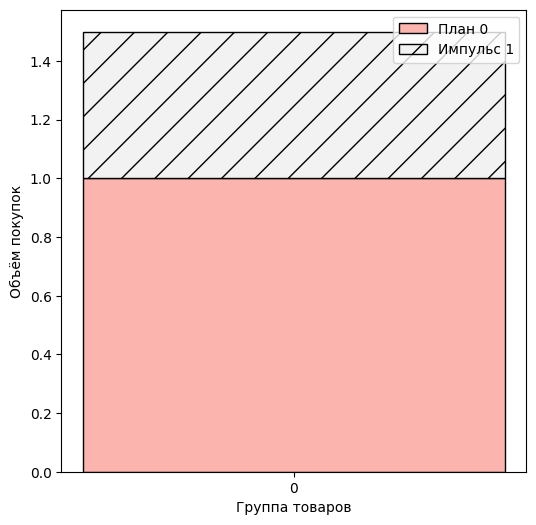

In [2]:
K_GROUPS = 1
K_CONS_GROUPS = 1
K_ADD_GROUPS = K_GROUPS
K_ACTIONS = 6

func = ImpulseFunc(base=0., coef=1.7, level=0.3)
cons_list = [ListConsumer(K_GROUPS, K_CONS_GROUPS, list_budget=1.),
             #ListConsumer(K_GROUPS, K_CONS_GROUPS, list_budget=0.5),
             ImpulseConsumer(K_GROUPS, K_ADD_GROUPS, func, add_budget=0.5)]
#cons_list[0].list_policy = np.array([0,0.5,0,0.5,0])
#cons_list[1].list_policy = np.array([0.25,0,0.25,0,0])
env = MarketEnv(K_GROUPS, k_actions=2, fix_stock=100, consumer_list=cons_list, max_ep=50, action_type='step', reward_type='diff')
policy_plot(env)

array([<Axes: xlabel='all_discount', ylabel='<Reward>'>,
       <Axes: xlabel='all_discount', ylabel='<Sold>'>], dtype=object)

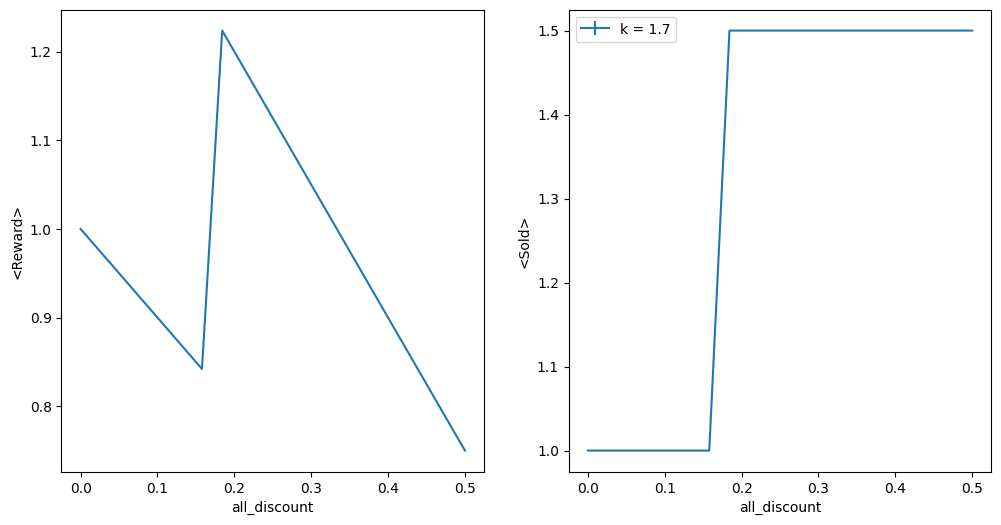

In [3]:
env.action_type = 'discount'
strategy_plot(env, variants=[1.7])

# Learning

In [4]:
from learning.DQN import manual_seed, train
from learning.utils import ReplayMemory
import random

env.action_type = 'step'
params = {
    'VERSION': 'DQN_step2',
    'BATCH_SIZE': 500,
    'GAMMA': 0.99,
    'EPS_START': 1.0,
    'EPS_END': 0.05,
    'N_EPS': 10000,
    'EPS_DECAY': 8000,
    'REPORT': 500,
    'MEMORY': 10000,
    'LR': 1e-4,
    'TAU': 0.1
    }

manual_seed(1234)
random.seed(1234)

In [5]:
import torch.nn as nn

class StepBrokerDRL(nn.Module):
    def __init__(self, k_groups: int = 5, k_actions:int = 2):
        super(StepBrokerDRL, self).__init__()
        
        # Проверяем корректность параметра
        if not 1 <= k_groups <= 10:
            raise ValueError("k_groups должен быть в диапазоне от 1 до 10")
        

        # Проверяем корректность параметра
        if not 2 <= k_actions <= 8:
            raise ValueError("k_actions должен быть в диапазоне от 2 до 8")

        # Определяем размеры слоев
        self.k_groups = k_groups
        self.k_actions = k_actions
        self.result_size = k_groups * k_actions  # [0, 0.5, k_act] на каждую группу 
        self.hidden_size = 96
        self.intermediate_size = 192
        self.big_size = 384
        
        # Создаем слои модели
        self.model = nn.Sequential(
            #nn.Conv2d(1,1,(2,1)),
            #nn.Flatten(1),
            #nn.Flatten(1),
            nn.Linear(k_groups, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.intermediate_size),
            nn.ReLU(),
            nn.Linear(self.intermediate_size, self.big_size),
            nn.ReLU(),
            nn.Linear(self.big_size, self.intermediate_size),
            nn.ReLU(),
            nn.Linear(self.intermediate_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.result_size)
            )        

    def forward(self, x):
        # Проверяем размерность входного тензора
        assert x.size(-1) == self.k_groups, \
            f"Входной вектор должен иметь размерность {self.k_groups}"
        x = self.model(x)
        x = x.unfold(-1, self.k_actions, self.k_actions) 
        return x       

In [6]:
import torch.nn as nn
from torch.optim import Adam



policy_Q=StepBrokerDRL(K_GROUPS, 2)
target_Q=StepBrokerDRL(K_GROUPS, 2)
target_Q.load_state_dict(policy_Q.state_dict())
# Compute Huber loss
criterion = nn.SmoothL1Loss()
#optimizer = Adagrad(policy_Q.parameters(), lr=params['LR'], lr_decay=1e-6)
optimizer = Adam(policy_Q.parameters(), lr=params['LR'])
device = "cpu"
memory = ReplayMemory(params['MEMORY'])

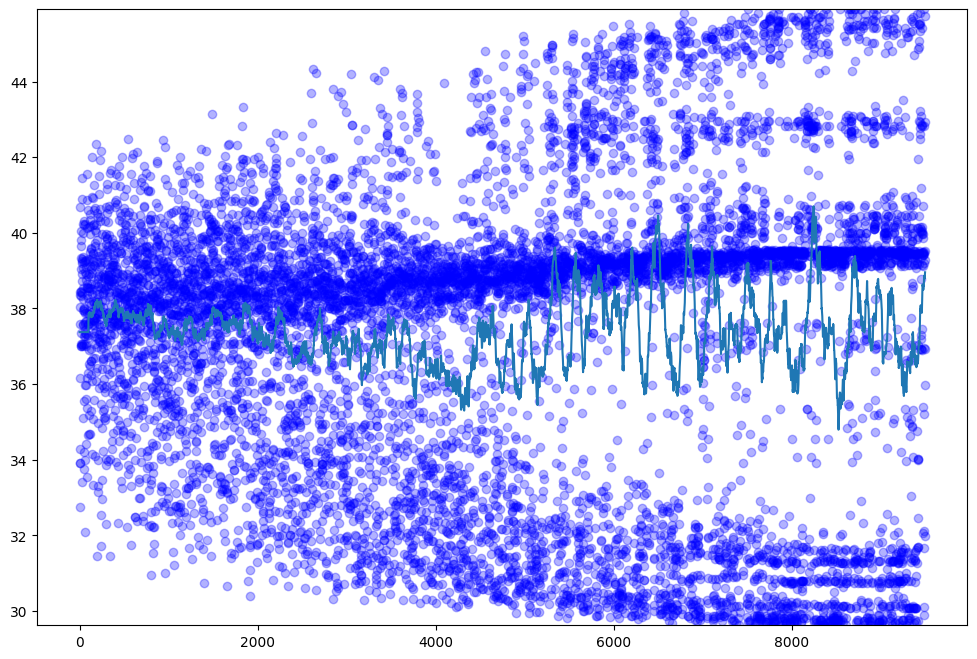

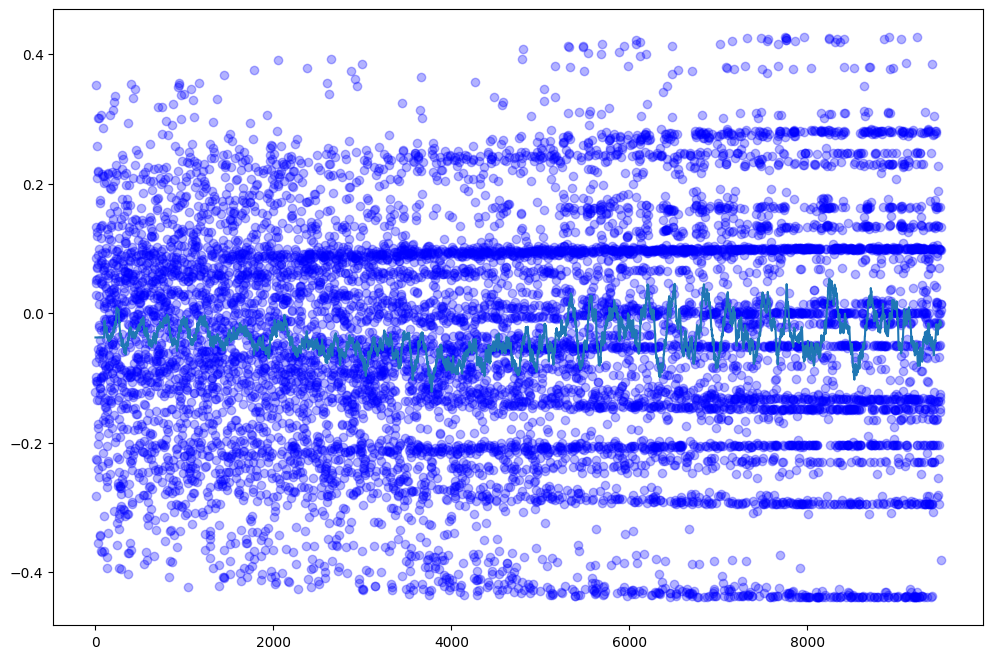

100%|██████████| 10000/10000 [02:21<00:00, 70.62it/s]

Complete


In [28]:
train(env, policy_Q, target_Q, criterion, optimizer, memory, device, params)

# Experiments

In [38]:
from torch import load 
target_Q = StepBrokerDRL(K_GROUPS, 2)
target_Q.load_state_dict(load('DQN_step2.pt')['MODEL'])

/var/folders/1r/nr0_b6h93gnbrdl1p0899fsh0000gn/T/ipykernel_45854/2712846454.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  target_Q.load_state_dict(load('DQN_step2.pt')

<All keys matched successfully>

In [39]:
N = 200
rs = []
env.reset()
for i in range(N):
    end = False
    reward = 0
    env.discount = np.array([0.])#,0.,0.,0.,0.])
    while not end:
        rews = target_Q(torch.tensor(env.state, dtype=torch.float32))
        _, r0, end, info = env.step(action=[0])#,0,0,0,0])
        reward += info['reward']
    rs.append(reward)
    env.reset()
print(f"{np.mean(rs):.2f} +- {np.std(rs) / np.sqrt(N):.2f} ")

50.00 +- 0.00 


In [40]:
N = 200
rs = []
env.reset()
for i in range(N):
    end = False
    reward = 0
    while not end:
        rews = target_Q(torch.tensor([env.state], dtype=torch.float32))
        action = rews.argmax(-1)
        _, r0, end, info = env.step(action.tolist()[0])
        reward += info['reward']
    rs.append(reward)
    env.reset()
print(f"{np.mean(rs):.2f} +- {np.std(rs) / np.sqrt(N):.2f} ")

57.86 +- 0.02 


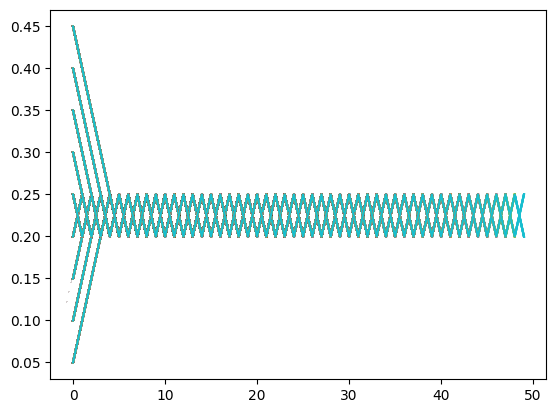

In [41]:
for i in range(11):
    end = False
    env.reset()
    env.discount = np.array([i/20])
    states0 = []
    while not end:
        rews = target_Q(torch.tensor([env.state], dtype=torch.float32))
        action = rews.argmax(-1)
        state, r0, end, info = env.step(action.tolist()[0])
        #print(state, round(info['reward'],2))
        states0.append(state[0])
        plt.plot(states0)

# Random

<Axes: xlabel='Группа товаров', ylabel='Объём покупок'>

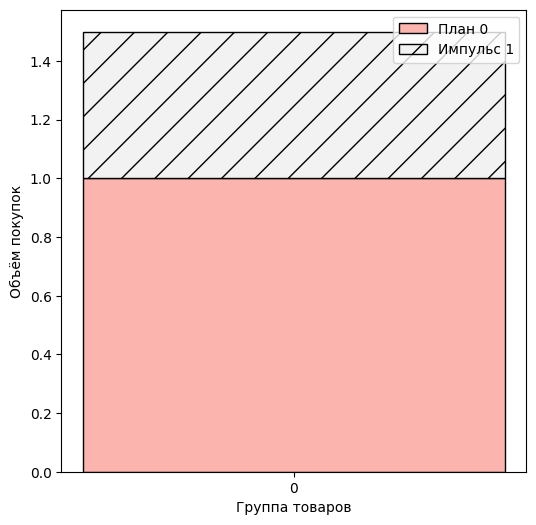

In [15]:
K_GROUPS = 1
K_CONS_GROUPS = 1
K_ADD_GROUPS = K_GROUPS
K_ACTIONS = 6

func = ImpulseFunc(base=0., coef=4.)
cons_list = [ListConsumer(K_GROUPS, K_CONS_GROUPS, list_budget=1.),
             #ListConsumer(K_GROUPS, K_CONS_GROUPS, list_budget=0.5),
             ImpulseConsumer(K_GROUPS, K_ADD_GROUPS, func, add_budget=0.5)]
#cons_list[0].list_policy = np.array([0,0.5,0,0.5,0])
#cons_list[1].list_policy = np.array([0.25,0,0.25,0,0])
env = MarketEnv(K_GROUPS, k_actions=2, fix_stock=100, consumer_list=cons_list, max_ep=50, action_type='step', reward_type='diff')
policy_plot(env)

array([<Axes: xlabel='all_discount', ylabel='<Reward>'>,
       <Axes: xlabel='all_discount', ylabel='<Sold>'>], dtype=object)

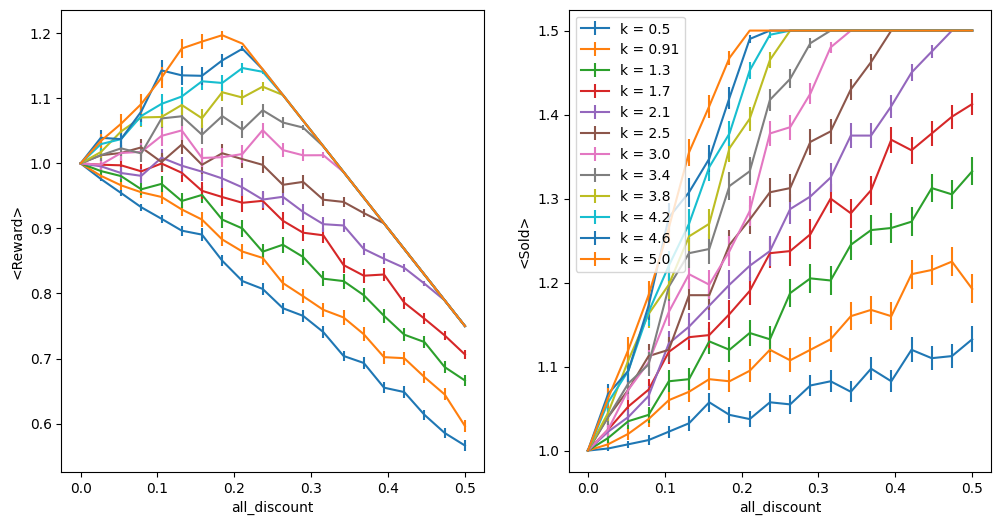

In [64]:
env.action_type = 'discount'
strategy_plot(env)

# Learning

In [70]:
from learning.DQN import manual_seed, train
from learning.utils import ReplayMemory
import random

env.action_type = 'step'
params['VERSION'] = 'DQN_step_random_40'
params['N_EPS'] = 20000

manual_seed(1234)
random.seed(1234)

In [71]:
import torch.nn as nn
import torch.nn as nn
from torch.optim import Adam

policy_Q=StepBrokerDRL(K_GROUPS, 2)
target_Q=StepBrokerDRL(K_GROUPS, 2)
target_Q.load_state_dict(policy_Q.state_dict())
# Compute Huber loss
criterion = nn.SmoothL1Loss()
#optimizer = Adagrad(policy_Q.parameters(), lr=params['LR'], lr_decay=1e-6)
optimizer = Adam(policy_Q.parameters(), lr=params['LR'])
device = "cpu"
memory = ReplayMemory(params['MEMORY'])      

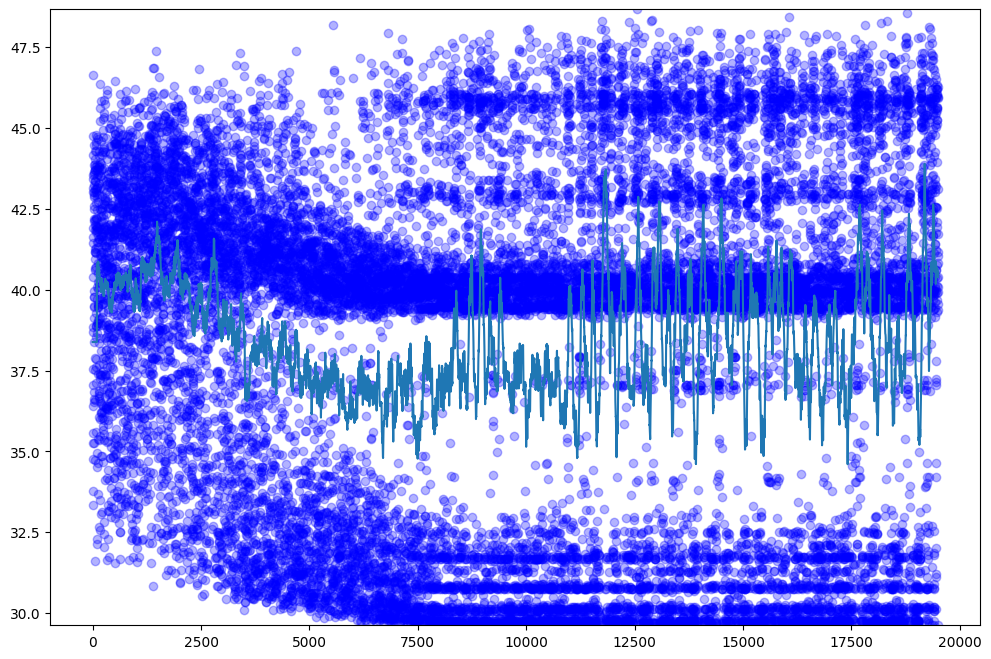

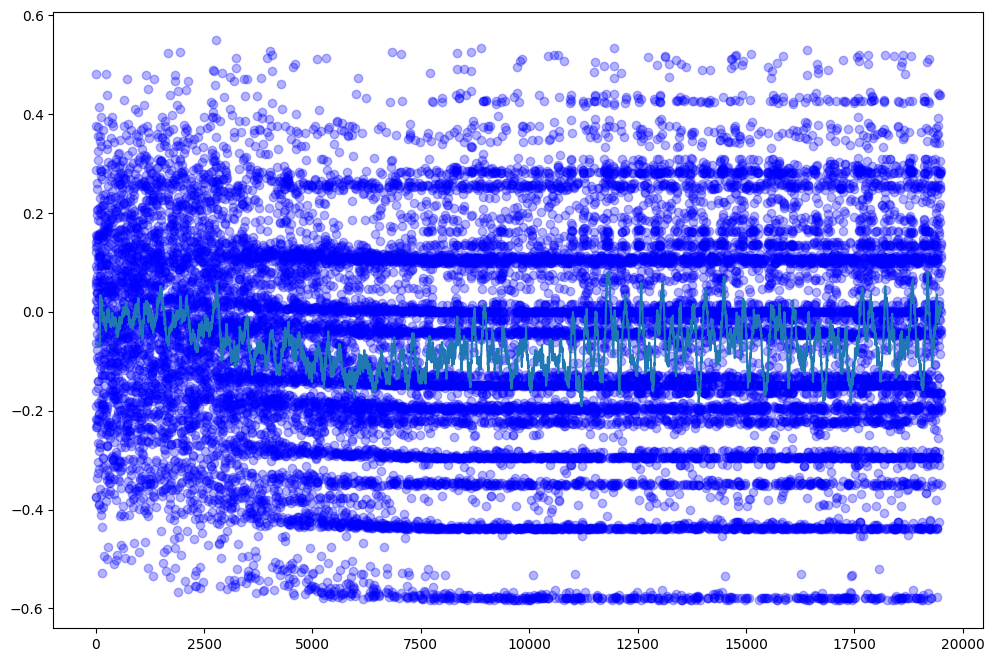

100%|██████████| 20000/20000 [05:00<00:00, 66.47it/s]

Complete


In [72]:
train(env, policy_Q, target_Q, criterion, optimizer, memory, device, params)

# Experiments

In [16]:
from torch import load 
target_Q = StepBrokerDRL(K_GROUPS, 2)
target_Q.load_state_dict(load('DQN_step_random_40.pt')['MODEL'])

N = 200
rs = []
env.reset()
for i in range(N):
    end = False
    reward = 0
    env.discount = np.array([0.])#,0.,0.,0.,0.])
    while not end:
        rews = target_Q(torch.tensor(env.state, dtype=torch.float32))
        _, r0, end, info = env.step(action=[0])#,0,0,0,0])
        reward += info['reward']
    rs.append(reward)
    env.reset()
print(f"{np.mean(rs):.2f} +- {np.std(rs) / np.sqrt(N):.2f} ")

N = 200
rs = []
env.reset()
for i in range(N):
    end = False
    reward = 0
    while not end:
        rews = target_Q(torch.tensor([env.state], dtype=torch.float32))
        action = rews.argmax(-1)
        _, r0, end, info = env.step(action.tolist()[0])
        reward += info['reward']
    rs.append(reward)
    env.reset()
print(f"{np.mean(rs):.2f} +- {np.std(rs) / np.sqrt(N):.2f} ")

/var/folders/1r/nr0_b6h93gnbrdl1p0899fsh0000gn/T/ipykernel_48859/2781167717.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  target_Q.load_state_dict(load('DQN_step_rando

50.00 +- 0.00 
56.05 +- 0.06 


Text(0, 0.5, 'D')

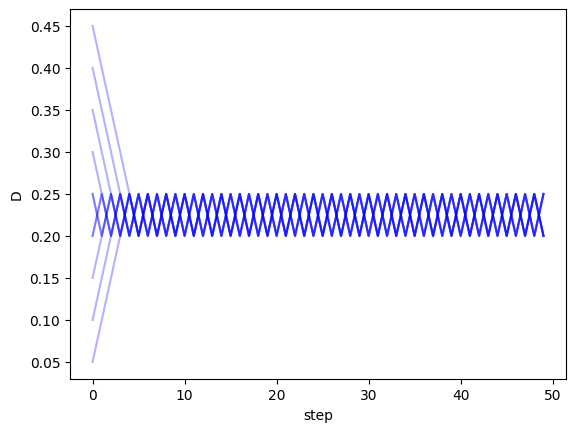

In [17]:
for i in range(11):
    end = False
    env.reset()
    env.discount = np.array([i/20])
    states0 = []
    while not end:
        rews = target_Q(torch.tensor([env.state], dtype=torch.float32))
        action = rews.argmax(-1)
        state, r0, end, info = env.step(action.tolist()[0])
        #print(state, round(info['reward'],2))
        states0.append(state[0])
    plt.plot(states0, color='blue', alpha=0.3)
plt.xlabel('step')
plt.ylabel('D')

# Random 1.7

<Axes: xlabel='Группа товаров', ylabel='Объём покупок'>

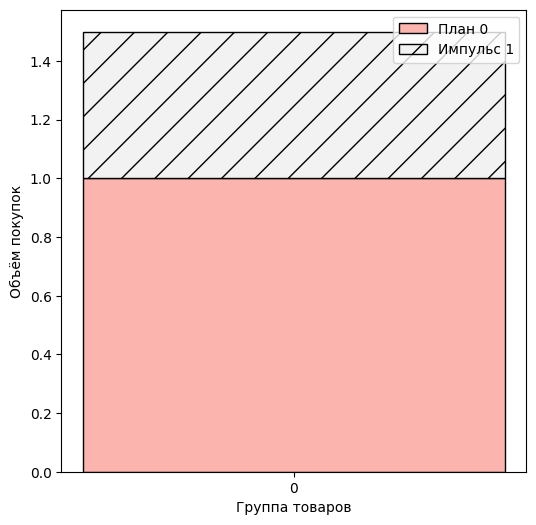

In [11]:
K_GROUPS = 1
K_CONS_GROUPS = 1
K_ADD_GROUPS = K_GROUPS
K_ACTIONS = 6

func = ImpulseFunc(base=0., coef=1.7)
cons_list = [ListConsumer(K_GROUPS, K_CONS_GROUPS, list_budget=1.),
             #ListConsumer(K_GROUPS, K_CONS_GROUPS, list_budget=0.5),
             ImpulseConsumer(K_GROUPS, K_ADD_GROUPS, func, add_budget=0.5)]
#cons_list[0].list_policy = np.array([0,0.5,0,0.5,0])
#cons_list[1].list_policy = np.array([0.25,0,0.25,0,0])
env = MarketEnv(K_GROUPS, k_actions=2, fix_stock=100, consumer_list=cons_list, max_ep=50, action_type='step', reward_type='diff')
policy_plot(env)

# Learning

In [76]:
from learning.DQN import manual_seed, train
from learning.utils import ReplayMemory
import random

env.action_type = 'step'
params['VERSION'] = 'DQN_step_random_17'
params['N_EPS'] = 20000

manual_seed(1234)
random.seed(1234)

In [77]:
import torch.nn as nn
import torch.nn as nn
from torch.optim import Adam

policy_Q=StepBrokerDRL(K_GROUPS, 2)
target_Q=StepBrokerDRL(K_GROUPS, 2)
target_Q.load_state_dict(policy_Q.state_dict())
# Compute Huber loss
criterion = nn.SmoothL1Loss()
#optimizer = Adagrad(policy_Q.parameters(), lr=params['LR'], lr_decay=1e-6)
optimizer = Adam(policy_Q.parameters(), lr=params['LR'])
device = "cpu"
memory = ReplayMemory(params['MEMORY'])      

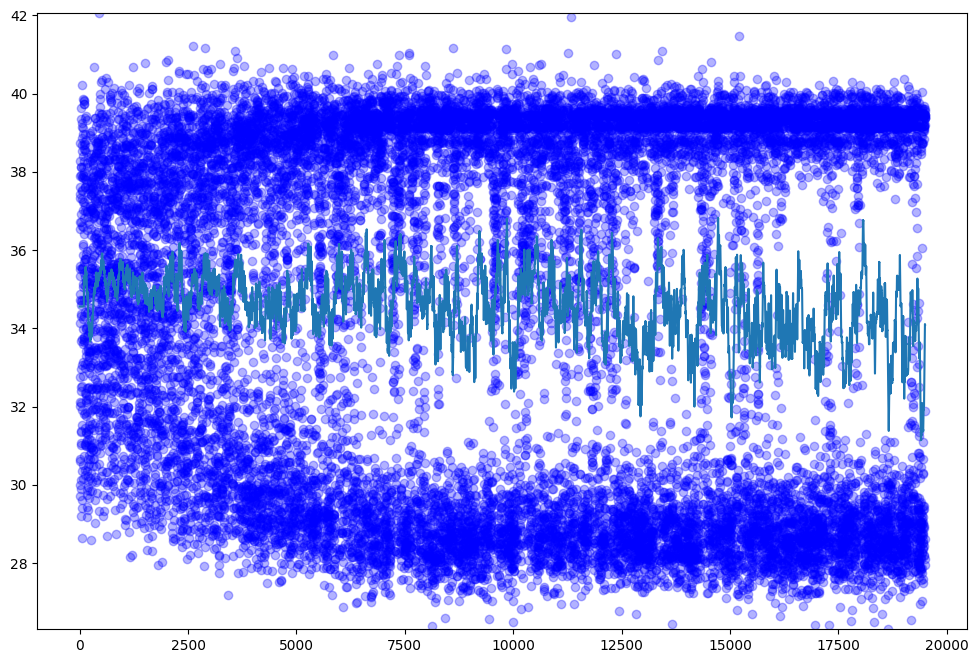

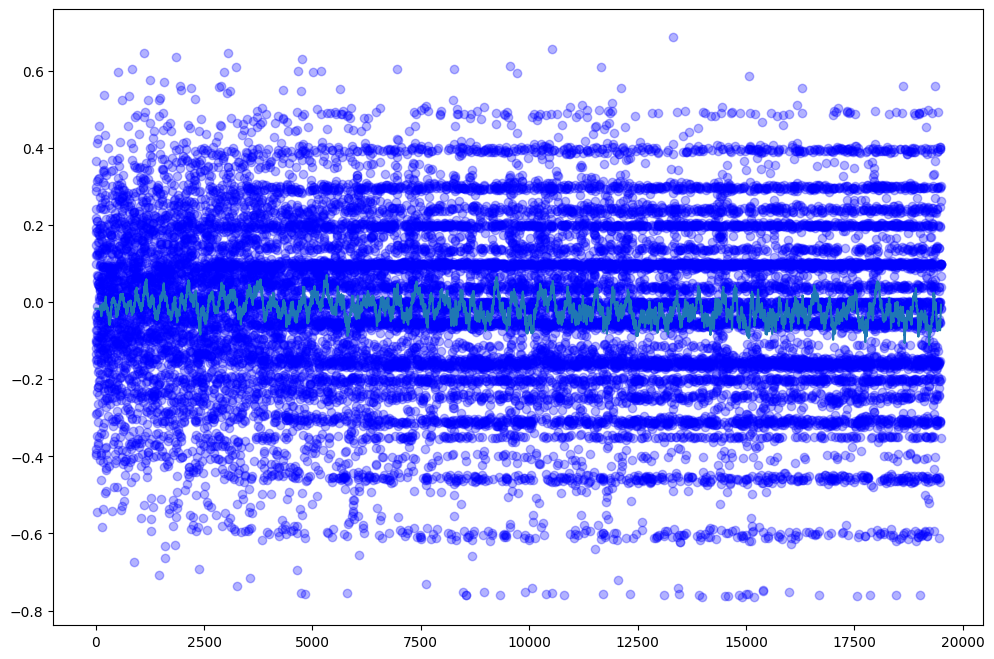

100%|██████████| 20000/20000 [04:54<00:00, 67.96it/s]

Complete


In [78]:
train(env, policy_Q, target_Q, criterion, optimizer, memory, device, params)

# Experiments

In [12]:
from torch import load 
target_Q = StepBrokerDRL(K_GROUPS, 2)
target_Q.load_state_dict(load('DQN_step_random_17.pt')['MODEL'])

N = 200
rs = []
env.reset()
for i in range(N):
    end = False
    reward = 0
    env.discount = np.array([0.])#,0.,0.,0.,0.])
    while not end:
        rews = target_Q(torch.tensor(env.state, dtype=torch.float32))
        _, r0, end, info = env.step(action=[0])#,0,0,0,0])
        reward += info['reward']
    rs.append(reward)
    env.reset()
print(f"{np.mean(rs):.2f} +- {np.std(rs) / np.sqrt(N):.2f} ")

N = 200
rs = []
env.reset()
for i in range(N):
    end = False
    reward = 0
    while not end:
        rews = target_Q(torch.tensor([env.state], dtype=torch.float32))
        action = rews.argmax(-1)
        _, r0, end, info = env.step(action.tolist()[0])
        reward += info['reward']
    rs.append(reward)
    env.reset()
print(f"{np.mean(rs):.2f} +- {np.std(rs) / np.sqrt(N):.2f} ")

/var/folders/1r/nr0_b6h93gnbrdl1p0899fsh0000gn/T/ipykernel_48859/2547500096.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  target_Q.load_state_dict(load('DQN_step_rando

50.00 +- 0.00 
49.75 +- 0.03 


Text(0, 0.5, 'D')

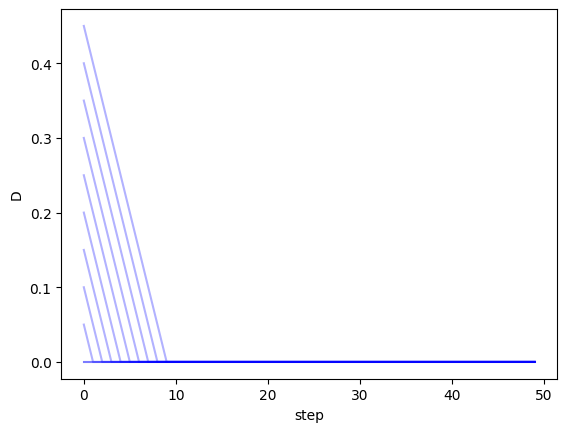

In [14]:
for i in range(11):
    end = False
    env.reset()
    env.discount = np.array([i/20])
    states0 = []
    while not end:
        rews = target_Q(torch.tensor([env.state], dtype=torch.float32))
        action = rews.argmax(-1)
        state, r0, end, info = env.step(action.tolist()[0])
        #print(state, round(info['reward'],2))
        states0.append(state[0])
    plt.plot(states0, color='blue', alpha=0.3)
plt.xlabel('step')
plt.ylabel('D')